# Dricksanalys

**Mål.**  
Vi vill:
1) beskriva dricksandelar,
2) testa om dricksandelen är högre vid middag än lunch (ensidigt test),
3) jämföra andel rökare helg vs vardag (proportionstest),
4) modellera dricks i dollar som funktion av notans storlek (enkel linjär regression).

**Data.**  
Vi använder ett publikt restaurang-dataset (244 kvitton) med bl.a. `total_bill`, `tip`, `time` (Lunch/Dinner), `smoker` (Yes/No), `day`, `size`.  
Vi skapar också `tip_pct = tip / total_bill` samt `weekend` (Sat/Sun).

## Slutsats och rekommendation

- **Genomsnittlig dricksandel** i datan ≈ **16%** (95 % CI ≈ **15.4-16.8 %**)
- **Måltid (Dinner vs Lunch)**: Hypotesen *Dinner > Lunch* får **inte** stöd (p ≈ 0.74); lunch ligger marginellt högre i urvalet men skillnaden är liten.
- **Rökare (helg vs vardag)**: ingen ststistiskt säker skillnad i andel rökare (p ≈ 0.75)
- **Samband**: dricks i dollar ökar ungefär **$1.05** per **$10** extra på notan.

**Rekommendation:** För att kunna prognostisera drick i dollar kan en linjär modell mot totalnota användas som enkel baslinje.  
vill man analysera nivåskillnader mellan grupper behövs större underlag, eftersom skillnaderna i det här urvalet är små och osäkra.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep
from sklearn.linear_model import LinearRegression

import seaborn as sns

In [4]:
tips = sns.load_dataset("tips").copy()
tips["tip_pct"] = tips["tip"] / tips["total_bill"]
tips["weekend"] = tips["day"].isin(["Sat", "Sun"]).map({True:"weekend", False:"weekday"})

print(f"Antal rader: {len(tips)}")
display(tips.head())
display(tips[["total_bill", "tip", "size", "tip_pct"]].describe())
display(tips.info())

Antal rader: 244


,total_bill,tip,sex,smoker,day,time,size,tip_pct,weekend
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447,weekend
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542,weekend
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587,weekend
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780,weekend
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808,weekend


,total_bill,tip,size,tip_pct
count,244.000000,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672,0.160803
std,8.902412,1.383638,0.951100,0.061072
min,3.070000,1.000000,1.000000,0.035638
25%,13.347500,2.000000,2.000000,0.129127
50%,17.795000,2.900000,2.000000,0.154770
75%,24.127500,3.562500,3.000000,0.191475
max,50.810000,10.000000,6.000000,0.710345


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    category
 6   size        244 non-null    int64   
 7   tip_pct     244 non-null    float64 
 8   weekend     244 non-null    object  
dtypes: category(4), float64(3), int64(1), object(1)
memory usage: 11.2+ KB


None

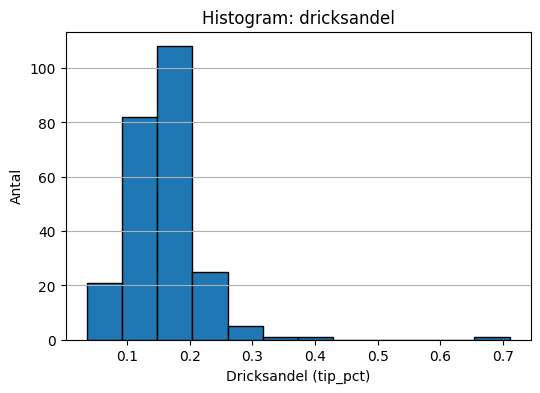

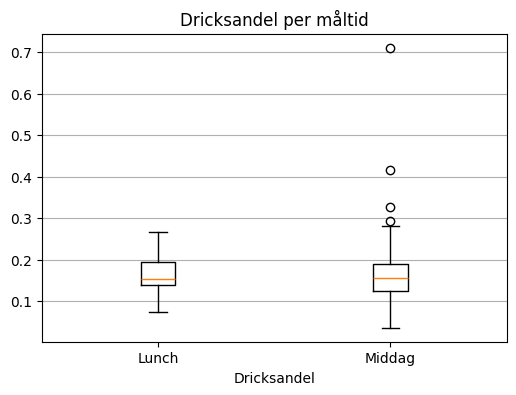

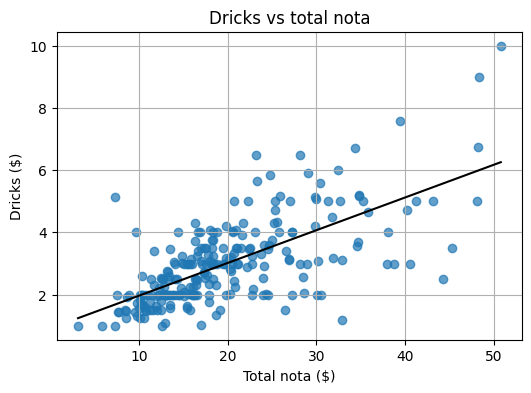

In [10]:
# Histogram tip_pct
plt.figure(figsize=(6,4))
plt.hist(tips["tip_pct"], bins=12, edgecolor="black")
plt.title("Histogram: dricksandel")
plt.xlabel("Dricksandel (tip_pct)")
plt.ylabel("Antal")
plt.grid(axis="y")
plt.show()

# Boxplot tip_pct per måltid
data_L = tips.loc[tips["time"] == "Lunch", "tip_pct"].values
data_D = tips.loc[tips["time"] == "Dinner", "tip_pct"].values

plt.figure(figsize=(6,4))
plt.boxplot([data_L, data_D], tick_labels=["Lunch", "Middag"])
plt.title("Dricksandel per måltid")
plt.xlabel("Dricksandel")
plt.grid(axis="y")
plt.show()


# Scatter tip($) vs total_bill ($) + enkel linje
x = tips["total_bill"].values
y = tips["tip"].values
coef = np.polyfit(x, y, deg=1)
x_line = np.linspace(x.min(), x.max(), 200)
y_line = coef[0] * x_line + coef[1]

plt.figure(figsize=(6,4))
plt.scatter(x, y, alpha=0.7)
plt.plot(x_line, y_line, color="black")
plt.title("Dricks vs total nota")
plt.xlabel("Total nota ($)")
plt.ylabel("Dricks ($)")
plt.grid(True)
plt.show()

## Medel dricksandel + osäkerhet (95% CI)

In [11]:
rng = np.random.default_rng(42)

tip_pct = tips["tip_pct"].values
n = tip_pct.size
mean_tip = tip_pct.mean()
sd_tip = tip_pct.std(ddof=1)
se_tip = sd_tip / np.sqrt(n)

z = 1.96
ci_low_norm = mean_tip - z * se_tip
ci_high_norm = mean_tip + z * se_tip


n_boot = 10_000
boot_means = []
for _ in range(n_boot):
    sample = rng.choice(tip_pct, size=n, replace=True)
    boot_means.append(sample.mean())
ci_low_boot, ci_high_boot = np.percentile(boot_means, [2.5, 97.5])

print(f"""
------------ Medel dricksandel -------------
n = {n}
Medel (tip_pct)     : {mean_tip*100:5.1f}%
SD                  : {sd_tip:0.6f}
SE                  : {se_tip:0.12f}
95% CI (normal)     : {ci_low_norm*100:4.1f}% till {ci_high_norm*100:4.1f}%
95% CI (bootstrap)  : {ci_low_boot*100:4.1f}% till {ci_high_boot*100:4.1f}%
""")


------------ Medel dricksandel -------------
n = 244
Medel (tip_pct)     :  16.1%
SD                  : 0.061072
SE                  : 0.003909747238
95% CI (normal)     : 15.3% till 16.8%
95% CI (bootstrap)  : 15.4% till 16.8%



## Ensidigt test: är dricksandelen högre vid **middag** än **lunch**?

**Hypoteser**  
H₀: Dinner = Lunch  
H₁: Dinner > Lunch

In [12]:
tip_pct_D = tips.loc[tips["time"] == "Dinner", "tip_pct"].values
tip_pct_L = tips.loc[tips["time"] == "Lunch", "tip_pct"].values

n_D, n_L = len(tip_pct_D), len(tip_pct_L)
mean_D, mean_L = tip_pct_D.mean(), tip_pct_L.mean()
diff_pp = (mean_D - mean_L) * 100

# Ensidigt t-test: Dinner > Lunch, Welch-variant
t_stat, p_one = stats.ttest_ind(
    tip_pct_D, tip_pct_L,
    equal_var=False,
    alternative="greater"
)

print(f"""
----------- Ensidigt test: Dinner > Lunch (dricksandel) -----------
n_Dinner, n_Lunch       : {n_D} {n_L}
Medel Dinner            : {mean_D: .3%}
Medel Lunch             : {mean_L: .3%}
Skillnad (D - L)        : {diff_pp: .1f} procentenheter
t-stat                  : {t_stat: .3f}
p (ensidigt, D>L)       : {p_one:.6f}
""")


----------- Ensidigt test: Dinner > Lunch (dricksandel) -----------
n_Dinner, n_Lunch       : 176 68
Medel Dinner            :  15.952%
Medel Lunch             :  16.413%
Skillnad (D - L)        : -0.5 procentenheter
t-stat                  : -0.654
p (ensidigt, D>L)       : 0.743082



**Fråga:** Är dricksandelen vid **middag** högre än vid **lunch**?

**Tolkning:** p-värdet är stort. Vi kan **inte** påvisa att middagsdricks är högre än lunch.  
Den observerade skillnaden är liten och går i motsatt riktning.

In [15]:
# Rökare helg/vardag
is_weekend = tips["day"].isin(["Sat", "Sun"])
smoker_yes = tips["smoker"] == "Yes"

x_weekend = (smoker_yes & is_weekend).sum()
n_weekend = is_weekend.sum()

x_weekday = (smoker_yes & ~is_weekend).sum()
n_weekday = (~is_weekend).sum()

p_weekend = x_weekend / n_weekend
p_weekday = x_weekday / n_weekday
diff_pp = (p_weekend - p_weekday) * 100


# Tvåsidigt z-test för två andelar
z_stat, p_two = proportions_ztest(
    count=[x_weekend, x_weekday],
    nobs=[n_weekend, n_weekday],
    alternative="two-sided"
)

# 95% CI för skillnaden i andelar (helg - vardag)
ci_low, ci_high = confint_proportions_2indep(
    count1=x_weekend, nobs1=n_weekend,
    count2=x_weekday, nobs2=n_weekday,
    method="score"
)

print(f"""
--- Proportionstest: rökare helg vs vardag (tvåsidigt) ---
Helg                            : {x_weekend} / {n_weekend} => {p_weekend: .1%}
Vardag                          : {x_weekday} / {n_weekday} => {p_weekday: .1%}
Skillnad (helg - vardag)        : {diff_pp: .1f} procentenheter
z-stat                          : {z_stat: .3f}
p (tvåsidigt)                   : {p_two: .6f}
95% CI för (p_helg - p_vardag)  : [{ci_low: .3f}, {ci_high: .3f}] (i andelar)
""")


--- Proportionstest: rökare helg vs vardag (tvåsidigt) ---
Helg                            : 61 / 163 =>  37.4%
Vardag                          : 32 / 81 =>  39.5%
Skillnad (helg - vardag)        : -2.1 procentenheter
z-stat                          : -0.315
p (tvåsidigt)                   :  0.752403
95% CI för (p_helg - p_vardag)  : [-0.151,  0.105] (i andelar)



**Tolkning:** Vi ser **ingen statistisk säkerställd skillnad** i andelen rökare mellan helg och vardag.  
Konfidensintervallet innehåller 0 och är relativt brett, vilket innebär att den sanna skillnaden kan vara nära noll eller liten åt något håll.  
Praktiskt: ingen tydlig helg/vardag-effekt i det här urvalet.


----- Regression: tip = a + b * total_bill -----
Skärning (dollar)       :  0.920
Lutning                 :  0.1050
R^2                     :  0.457
Tolkning lutning: +10$ nota => +  1.05$ dricks (i snitt)



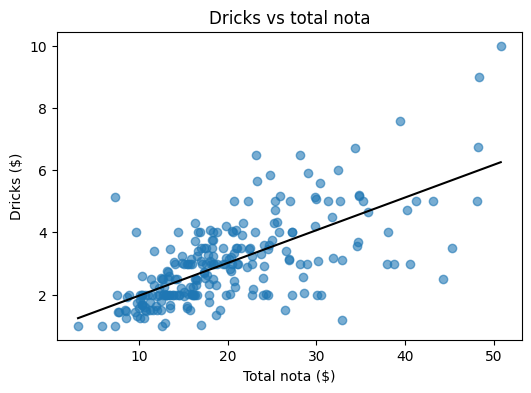

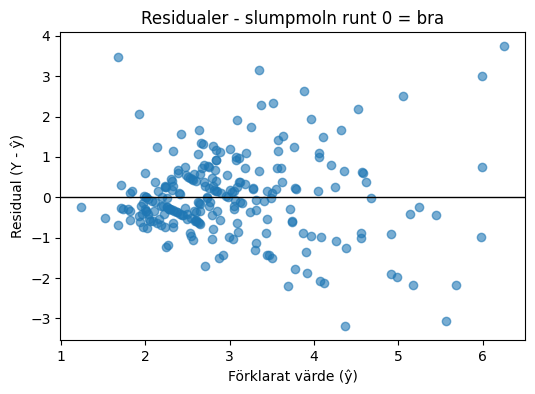

In [16]:
X = tips[["total_bill"]].to_numpy()
y = tips["tip"].to_numpy()

model = LinearRegression()
model.fit(X, y)

intercept_hat = float(model.intercept_)
slope_hat = float(model.coef_[0])

y_hat = model.predict(X)
residuals = y - y_hat

# R^2
ss_tot = np.sum((y - y.mean())**2)
ss_res = np.sum((residuals)**2)
r2 = 1 - ss_res / ss_tot

print(f"""
----- Regression: tip = a + b * total_bill -----
Skärning (dollar)       : {intercept_hat: .3f}
Lutning                 : {slope_hat: .4f}
R^2                     : {r2: .3f}
Tolkning lutning: +10$ nota => + {10 * slope_hat: .2f}$ dricks (i snitt)
""")

plt.figure(figsize=(6,4))
plt.scatter(X[:,0], y, alpha=0.6)
x_line = np.linspace(X.min(), X.max(), 100)
y_line = intercept_hat + slope_hat * x_line
plt.plot(x_line, y_line, color="black")
plt.xlabel("Total nota ($)")
plt.ylabel("Dricks ($)")
plt.title("Dricks vs total nota")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(y_hat, residuals, alpha=0.6)
plt.axhline(0, color="black", linewidth=1)
plt.xlabel("Förklarat värde (ŷ)")
plt.ylabel("Residual (Y - ŷ)")
plt.title("Residualer - slumpmoln runt 0 = bra")
plt.show()